# Converting UI Loss to Sparse

In [15]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.data import Batch
from time import time

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../")
device = "cuda" if torch.cuda.is_available() else "cpu"

from lightning_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load config
with open("../configs/influencer_trackml_transformer_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [5]:
model = InfluencerTransformer(config)

## Test Dataloading

In [6]:
model.setup(stage="fit");

Setting up the data...


In [7]:
sample = model.valset[0]

KeyboardInterrupt: 

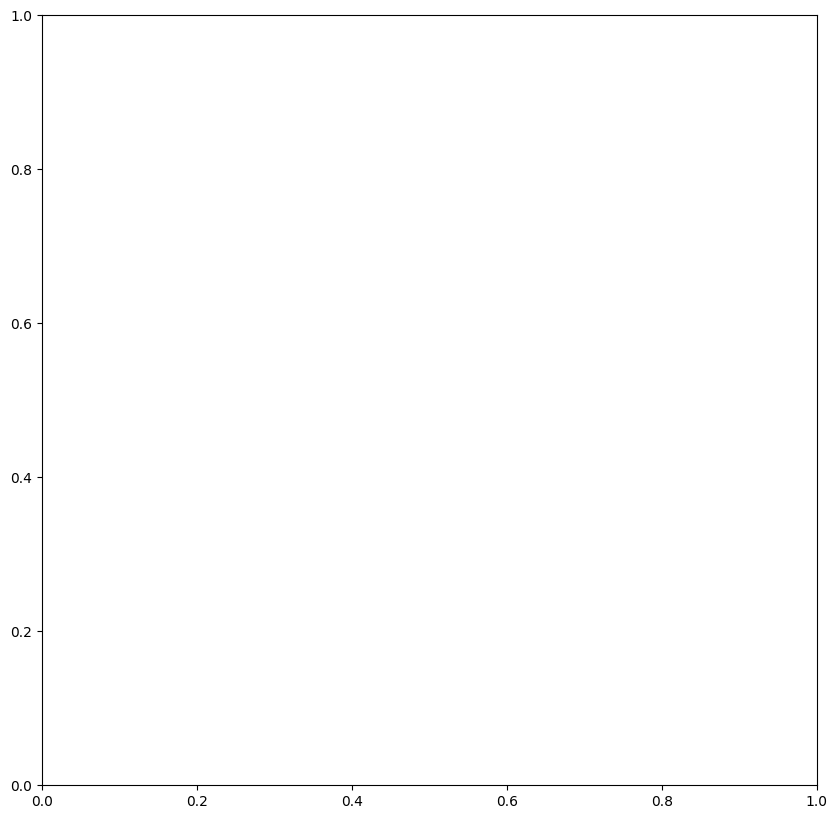

In [8]:
# Plot the graph
def plot_graph(sample):
    _, ax = plt.subplots(figsize=(10,10))
    ax.plot(sample.x[sample.edge_index,0], sample.x[sample.edge_index,1], c='b', alpha=0.1, linewidth=2)
    ax.scatter(sample.x[:,0], sample.x[:,1], s=10, c="k")
    plt.show()

plot_graph(sample)

## Study Train Loop

In [9]:
model = model.to(device)

In [29]:
%%time
for batch in model.train_dataloader():
    batch = batch.to(device)
    print(batch)

    # Get the user and influencer embeddings
    input_data = model.get_input_data(batch)
    # time
    tic = time()
    with torch.no_grad():
        user_embed, influencer_embed = model(input_data, batch.batch)
    print(f"Time to get embeddings: {time() - tic}")
    
    # Get the training edges for each loss function
    tic = time()
    user_user_edges, user_user_truth = model.get_training_edges(batch, user_embed, user_embed, hnm=True, rp=True, tp=True, batch_index = batch.batch)
    print(f"Time to get user-user edges: {time() - tic}")
    tic = time()
    user_influencer_edges, user_influencer_truth = model.get_training_edges(batch, user_embed, influencer_embed, hnm=True, tp=True, rp=True, batch_index = batch.batch)
    print(f"Time to get user-influencer edges: {time() - tic}")
    tic = time()
    influencer_influencer_edges, influencer_influencer_truth = model.get_training_edges(batch, influencer_embed, influencer_embed, hnm=True, rp=True, radius=model.hparams["influencer_margin"], batch_index = batch.batch)
    print(f"Time to get influencer-influencer edges: {time() - tic}")

    # Get the hits of interest
    tic = time()
    included_hits = torch.cat([user_user_edges, user_influencer_edges, influencer_influencer_edges], dim=1).unique()
    user_embed[included_hits], influencer_embed[included_hits] = model(input_data[included_hits], batch.batch[included_hits])
    print(f"Time to get hits of interest: {time() - tic}")
    
    # Calculate each loss function
    tic = time()
    user_user_loss = model.get_user_user_loss(user_user_edges, user_user_truth, user_embed)
    print(f"Time to calculate user user losses: {time() - tic}")
    tic = time()
    user_influencer_loss = model.get_user_influencer_loss(user_influencer_edges, user_influencer_truth, user_embed, influencer_embed, batch)
    print(f"Time to calculate user influencer losses: {time() - tic}")
    tic = time()
    influencer_influencer_loss = model.get_influencer_influencer_loss(influencer_influencer_edges, influencer_influencer_truth, influencer_embed)
    print(f"Time to calculate influencer influencer losses: {time() - tic}")


    break

DataBatch(x=[11324, 6], num_nodes=11324, pid=[11324], edge_index=[2, 135524], batch=[11324], ptr=[2])
Time to get embeddings: 0.09512567520141602
Time to get user-user edges: 0.03986382484436035
Time to get user-influencer edges: 0.07652163505554199
Time to get influencer-influencer edges: 0.03825879096984863
Time to get hits of interest: 0.10184860229492188
Time to calculate user user losses: 0.007383823394775391
Positive loss tensor(13.3821, device='cuda:0', grad_fn=<MeanBackward0>)
Time to calculate user influencer losses: 1.6805224418640137
Time to calculate influencer influencer losses: 0.0008809566497802734
CPU times: user 32.8 s, sys: 909 ms, total: 33.7 s
Wall time: 2.31 s


In [20]:
pid = torch.tensor([0, 1, 1, 0, 2, 2, 0, 1]) + 10


In [22]:
_, inverse_pid = torch.unique(pid, return_inverse=True)

In [23]:
inverse_pid

tensor([0, 1, 1, 0, 2, 2, 0, 1])

In [ ]:
Positive loss tensor(13.4049, device='cuda:0', grad_fn=<MeanBackward0>)
Positive loss tensor(13.3886, device='cuda:0', grad_fn=<MeanBackward0>)